In [2]:
from FastSurfer.FastSurferCNN.data_loader.load_neuroimaging_data import load_and_conform_image
import nibabel as nib
from nibabel.processing import conform
import pandas as pd
import matplotlib.pyplot as plt

from PIL import ImageFilter
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torch.nn import CrossEntropyLoss

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import os
import random
from pathlib import Path
import joblib

# Data Processing and Loading

In [3]:
df_info = pd.read_csv('data/info.csv')

ORDER_MAP = {'Artiodactyla':0,
 'Carnivora':1,
 'Chiroptera':2,
 'Eulipotyphla':3,
 'Hyracoidea':4,
 'Lagomorpha':5,
 'Marsupialia':6,
 'Perissodactyla':7,
 'Primates':8,
 'Rodentia':9,
 'Scandentia':10,
 'Xenarthra':11}

def normalize_image(img):
    img += abs(img.min())
    img /= img.max()
    return img

from augmentations import Crop
        
def process_raw_image(datadir, f, order, outputdir):
    if order.empty:
        order = df_info[df_info.Filename.str.fullmatch(f.stem[:f.stem.find('_')])].Order.drop_duplicates()
    if order.size != 1:
        print(f)
        print(order)
        return ''
    
    img = nib.load(f)
    img = img.get_fdata()
    img = np.nan_to_num(img)
    img = normalize_image(img)
    
    crop = Crop([80,80,32],"random")
    
    annotations = ""
    for i in range(20):
        joblib.dump([crop(img),order], outputdir + f'Processed/{f.stem}_{i}.joblib')
        annotations += f'{f.stem}_{i}.joblib,{ORDER_MAP[order.values[0]]}\n'
    #img = img[20:100,20:100,50:82]
    #img_arr = trim(img, img != img[0,0,0])
    #print(f'{f} - {img_arr.shape}')
    #img = nib.Nifti1Image(a,affine=img.affine)
    #img = conform(img, out_shape=(256, 256, 256), ).get_fdata()
    
    #trimmed = trim(img, img != img[0,0,0])
    #print(f'{trimmed.shape}')
    
    return annotations

def process_raw_images(inputdir='MRI', datadir='data/', outputdir='data/', order=pd.Series(dtype=str)):
    annotations = 'filename,order\n'
    for f in tqdm((Path(datadir)/inputdir).iterdir()):
        annotations += process_raw_image(datadir, f, order, outputdir)
    with open(Path(datadir)/'labels.csv', 'w') as f:
        f.write(annotations)
        
def load_processed(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'Processed').iterdir():
        train_loader.append(joblib.load(f))
    return train_loader

def load_raw(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'MRI').iterdir():
        order = df_info[df_info.Filename.str.contains(f.stem[:f.stem.find('_')-1])].Order.drop_duplicates()
        if order.size > 1:
            print(order)
            continue
        img = nib.load(f).get_fdata()
        train_loader.append([img, order])
    return train_loader

def trim(arr, mask):
    bounding_box = tuple(
        slice(np.min(indexes), np.max(indexes) + 1)
        for indexes in np.where(mask))
    return arr[bounding_box]
    

In [4]:
process_raw_images('Resampled')

2it [00:00, 11.46it/s]

data\Resampled\.nii.gz
Series([], Name: Order, dtype: object)


53it [00:11,  4.79it/s]


In [217]:
process_raw_images('Resampled', datadir='f:/Data/OpenNeuro/ds004114-download/', outputdir='f:/Data/OpenNeuro/', order=pd.Series(['Rodentia']))

751it [00:41, 17.97it/s]


In [218]:
process_raw_images('Resampled', datadir='f:/Data/OpenNeuro/ds004215-download/', outputdir='f:/Data/OpenNeuro/', order=pd.Series(['Primates']))

153it [00:08, 17.65it/s]


### Train Test split

In [14]:
df_info = pd.read_csv('data/labels.csv')
df_info = df_info.loc[df_info['order'].isin([0,1])]

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_info, test_size=0.33, random_state=42)

In [16]:
train.to_csv("data/train.csv", index=False)

In [17]:
test.to_csv("data/test.csv", index=False)

In [51]:
df_info = pd.read_csv('f:/Data/OpenNeuro/labels.csv')

In [52]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_info, test_size=0.33, random_state=42)

In [54]:
train.to_csv("f:/Data/OpenNeuro//train.csv", index=False)

In [55]:
test.to_csv("f:/Data/OpenNeuro//test.csv", index=False)

## Print All Data

In [85]:
images = []
for f in Path('f:/Data/OpenNeuro/ds004114-download/Resampled/').iterdir():
    images.append(nib.load(f).get_fdata())
    if len(images) > 20:
        break

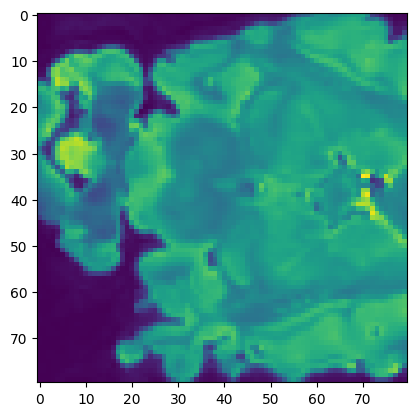

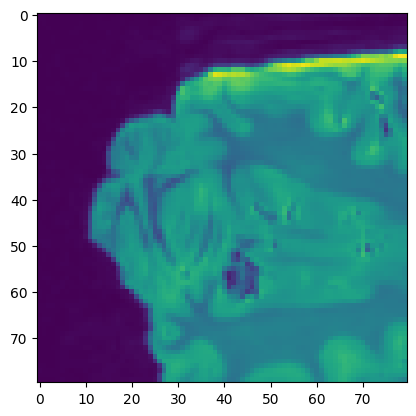

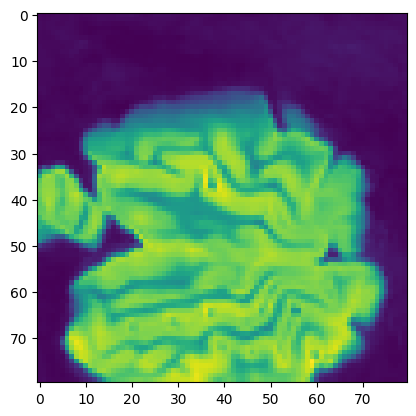

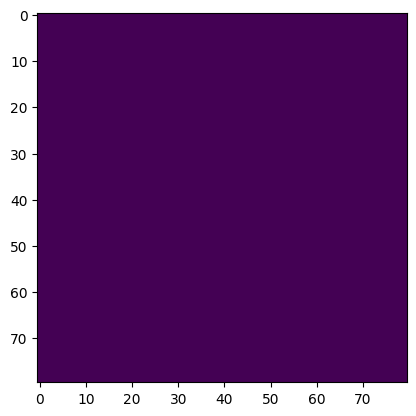

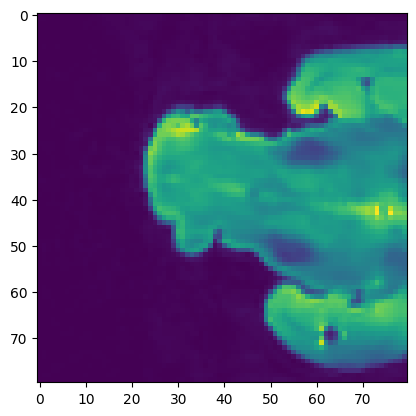

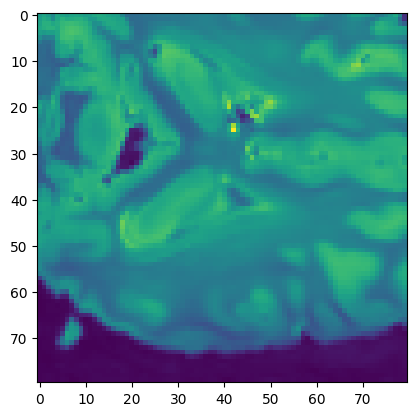

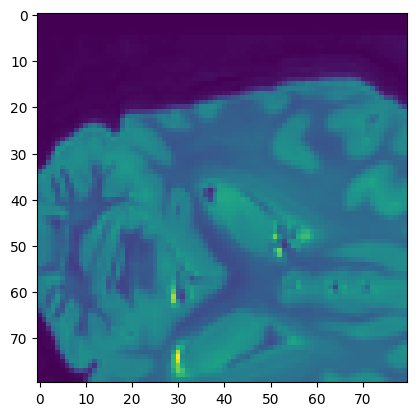

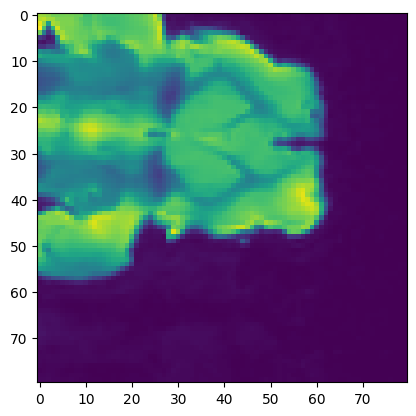

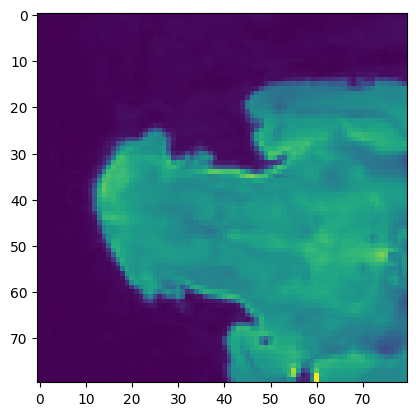

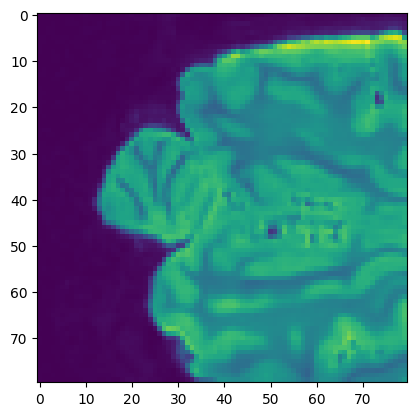

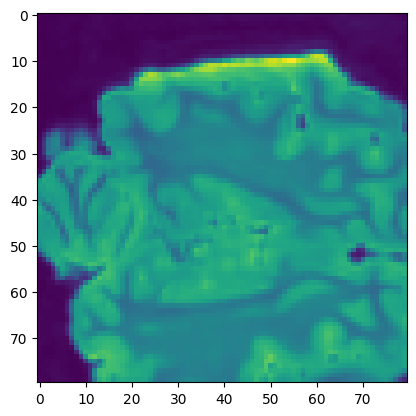

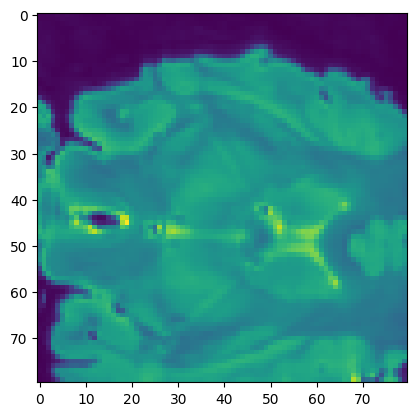

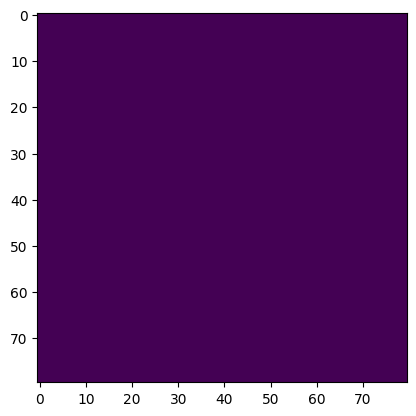

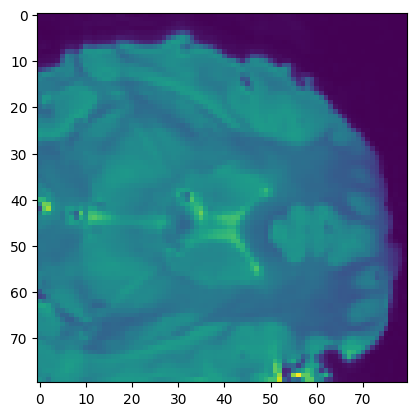

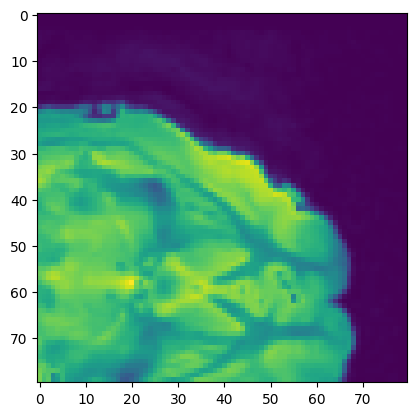

In [13]:
for img in images[:15]:
    plt.figure()
    plt.imshow(img[:,:,5])
plt.show()

In [5]:
images = []
for f in Path('data/Processed/').iterdir():
    images.append(joblib.load(f)[0])
    if len(images) > 20:
        break

# Training

## Train And Validation loss

In [240]:
model = torch.load('checkpoint/ntxent_Contrastive_MRI_epoch_50.pth')
losses = model['losses']

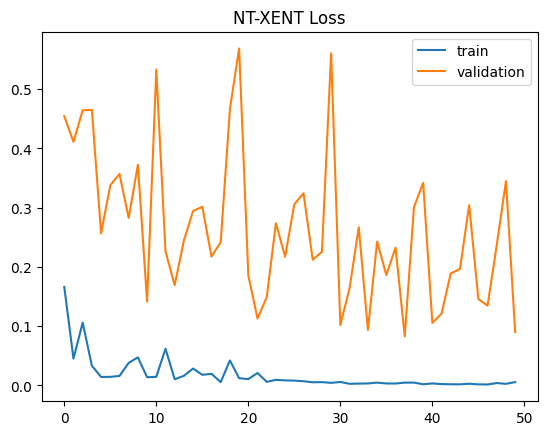

In [241]:
plt.plot(range(len(losses['train'])), losses['train'], label="train")
plt.plot(range(len(losses['validation'])), losses['validation'], label="validation")
plt.legend()
plt.title('NT-XENT Loss')
plt.show()

In [13]:
model = torch.load('checkpoint/fine_tune_epoch_50.pth')
losses = model['losses']

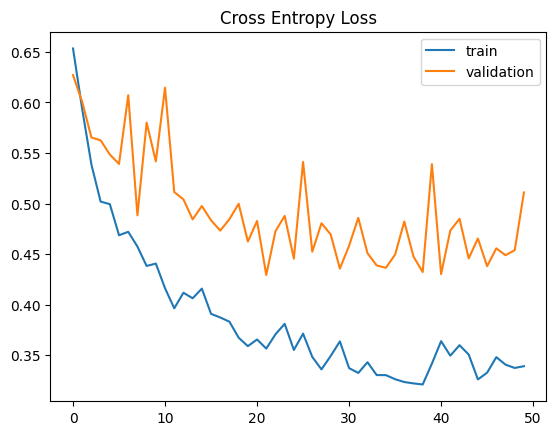

In [14]:
plt.plot(range(len(losses['train'])), losses['train'], label="train")
plt.plot(range(len(losses['validation'])), losses['validation'], label="validation")
plt.legend()
plt.title('Cross Entropy Loss')
plt.show()

In [109]:
model = torch.load('checkpoint/fine_tune_epoch_50.pth')
losses = model['losses']

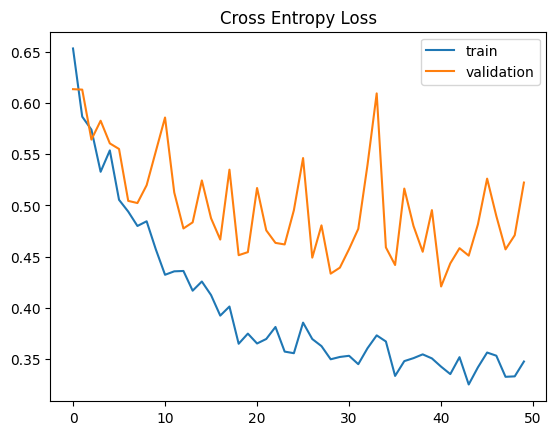

In [110]:
plt.plot(range(len(losses['train'])), losses['train'], label="train")
plt.plot(range(len(losses['validation'])), losses['validation'], label="validation")
plt.legend()
plt.title('Cross Entropy Loss')
plt.show()

In [26]:
from config import Config, PRETRAINING, FINE_TUNING
from dataset import CustomImageDataset
dataset_train = CustomImageDataset('f:/Data/OpenNeuro/train.csv', 'f:/Data/OpenNeuro/Processed/', PRETRAINING)
config = Config(PRETRAINING)
loader_train = DataLoader(dataset_train,
                              batch_size=config.batch_size,
                              sampler=RandomSampler(dataset_train),
                              pin_memory=config.pin_mem,
                              num_workers=config.num_cpu_workers
                              )

## SWaV

In [8]:
def train(train_loader, model, optimizer, epoch, lr_schedule, queue):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train()
    use_the_queue = False

    end = time.time()
    for it, inputs in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # update learning rate
        iteration = epoch * len(train_loader) + it
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr_schedule[iteration]

        # normalize the prototypes
        with torch.no_grad():
            w = model.module.prototypes.weight.data.clone()
            w = nn.functional.normalize(w, dim=1, p=2)
            model.module.prototypes.weight.copy_(w)

        # ============ multi-res forward passes ... ============
        embedding, output = model(inputs)
        embedding = embedding.detach()
        bs = inputs[0].size(0)

        # ============ swav loss ... ============
        loss = 0
        for i, crop_id in enumerate(args.crops_for_assign):
            with torch.no_grad():
                out = output[bs * crop_id: bs * (crop_id + 1)].detach()

                # time to use the queue
                if queue is not None:
                    if use_the_queue or not torch.all(queue[i, -1, :] == 0):
                        use_the_queue = True
                        out = torch.cat((torch.mm(
                            queue[i],
                            model.module.prototypes.weight.t()
                        ), out))
                    # fill the queue
                    queue[i, bs:] = queue[i, :-bs].clone()
                    queue[i, :bs] = embedding[crop_id * bs: (crop_id + 1) * bs]

                # get assignments
                q = distributed_sinkhorn(out)[-bs:]

            # cluster assignment prediction
            subloss = 0
            for v in np.delete(np.arange(np.sum(args.nmb_crops)), crop_id):
                x = output[bs * v: bs * (v + 1)] / args.temperature
                subloss -= torch.mean(torch.sum(q * F.log_softmax(x, dim=1), dim=1))
            loss += subloss / (np.sum(args.nmb_crops) - 1)
        loss /= len(args.crops_for_assign)

        # ============ backward and optim step ... ============
        optimizer.zero_grad()
        if args.use_fp16:
            with apex.amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        # cancel gradients for the prototypes
        if iteration < args.freeze_prototypes_niters:
            for name, p in model.named_parameters():
                if "prototypes" in name:
                    p.grad = None
        optimizer.step()

        # ============ misc ... ============
        losses.update(loss.item(), inputs[0].size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        if args.rank ==0 and it % 50 == 0:
            logger.info(
                "Epoch: [{0}][{1}]\t"
                "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "Data {data_time.val:.3f} ({data_time.avg:.3f})\t"
                "Loss {loss.val:.4f} ({loss.avg:.4f})\t"
                "Lr: {lr:.4f}".format(
                    epoch,
                    it,
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    lr=optimizer.optim.param_groups[0]["lr"],
                )
            )
    return (epoch, losses.avg), queue

@torch.no_grad()
def distributed_sinkhorn(out):
    Q = torch.exp(out / args.epsilon).t() # Q is K-by-B for consistency with notations from our paper
    B = Q.shape[1] * args.world_size # number of samples to assign
    K = Q.shape[0] # how many prototypes

    # make the matrix sums to 1
    sum_Q = torch.sum(Q)
    dist.all_reduce(sum_Q)
    Q /= sum_Q

    for it in range(args.sinkhorn_iterations):
        # normalize each row: total weight per prototype must be 1/K
        sum_of_rows = torch.sum(Q, dim=1, keepdim=True)
        dist.all_reduce(sum_of_rows)
        Q /= sum_of_rows
        Q /= K

        # normalize each column: total weight per sample must be 1/B
        Q /= torch.sum(Q, dim=0, keepdim=True)
        Q /= B

    Q *= B # the colomns must sum to 1 so that Q is an assignment
    return Q.t()

# Inference

## Get predictions

In [82]:
from dataset import CustomImageDataset
from config import Config, FINE_TUNING

config = Config(FINE_TUNING)

dataset_test = CustomImageDataset(config, 'data/test.csv', 'data/Processed/', FINE_TUNING)
loader_test = DataLoader(dataset_test,
                          batch_size=config.batch_size,
                          pin_memory=config.pin_mem,
                          num_workers=config.num_cpu_workers
                          )

def get_predictions(net, is_encoder=False):
    from sklearn.metrics import ConfusionMatrixDisplay

    y_pred = []
    y_true = []
    for inputs, labels, paths in loader_test:
        if is_encoder:
            output = net(inputs).data.cpu().numpy()
        else:
            output = torch.max(net(inputs), 1)[1].data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
    return y_pred, y_true

## Load the classifier and classify

In [113]:
from models.densenet import densenet121

model = torch.load('checkpoint/fine_tune_epoch_22_80_80_32_mam.pth')
net = densenet121(mode="classifier", drop_rate=0.0, num_classes=2)
net = torch.nn.DataParallel(net).to('cuda')
net.load_state_dict(model['model'])
y_pred, y_true = get_predictions(net)

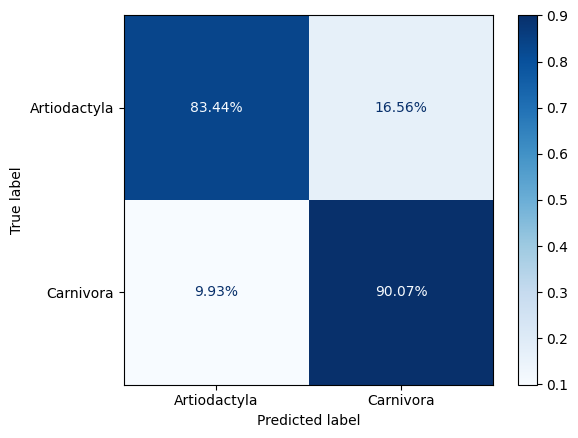

In [114]:
classes = ['Artiodactyla', 'Carnivora']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes, cmap='Blues', values_format='.2%', normalize='true')
plt.show()

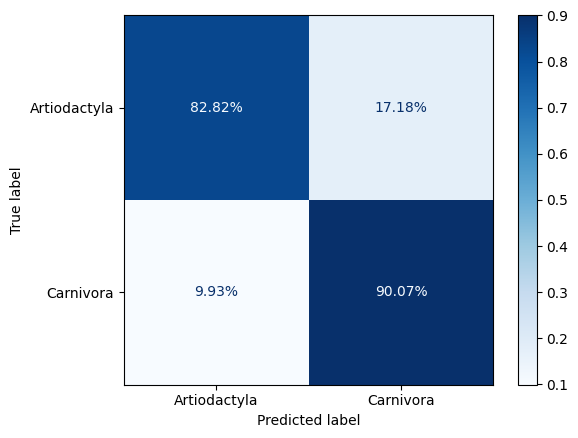

In [112]:
classes = ['Artiodactyla', 'Carnivora']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes, cmap='Blues', values_format='.2%', normalize='true')
plt.show()

# Latent Space Visualization

In [85]:
from sklearn.manifold import TSNE

model = torch.load('checkpoint/ntxent_Contrastive_MRI_epoch_50_80_80_32_mam.pth')
net = densenet121(mode="encoder", drop_rate=0.0, num_classes=2)
net = torch.nn.DataParallel(net).to('cuda')
net.load_state_dict(model['model'])
y_pred, y_true = get_predictions(net, is_encoder=True)

In [96]:
summary(net)

Layer (type:depth-idx)                   Param #
├─DenseNet: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─Conv3d: 3-1                  21,952
|    |    └─BatchNorm3d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool3d: 3-4               --
|    |    └─_DenseBlock: 3-5             777,408
|    |    └─_Transition: 3-6             33,280
|    |    └─_DenseBlock: 3-7             1,804,416
|    |    └─_Transition: 3-8             132,096
|    |    └─_DenseBlock: 3-9             4,607,232
|    |    └─_Transition: 3-10            526,336
|    |    └─_DenseBlock: 3-11            3,337,728
|    └─Linear: 2-2                       524,800
|    └─Linear: 2-3                       65,664
Total params: 11,831,040
Trainable params: 11,831,040
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─DenseNet: 1-1                          --
|    └─Sequential: 2-1                   --
|    |    └─Conv3d: 3-1                  21,952
|    |    └─BatchNorm3d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool3d: 3-4               --
|    |    └─_DenseBlock: 3-5             777,408
|    |    └─_Transition: 3-6             33,280
|    |    └─_DenseBlock: 3-7             1,804,416
|    |    └─_Transition: 3-8             132,096
|    |    └─_DenseBlock: 3-9             4,607,232
|    |    └─_Transition: 3-10            526,336
|    |    └─_DenseBlock: 3-11            3,337,728
|    └─Linear: 2-2                       524,800
|    └─Linear: 2-3                       65,664
Total params: 11,831,040
Trainable params: 11,831,040
Non-trainable params: 0

In [107]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, n_iter=10000, learning_rate=0.1)
z = tsne.fit_transform(y_pred) 

c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 304 samples in 0.000s...
[t-SNE] Computed neighbors for 304 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 304 / 304
[t-SNE] Mean sigma: 0.178948
[t-SNE] KL divergence after 200 iterations with early exaggeration: 56.157681
[t-SNE] KL divergence after 6400 iterations: 0.681303


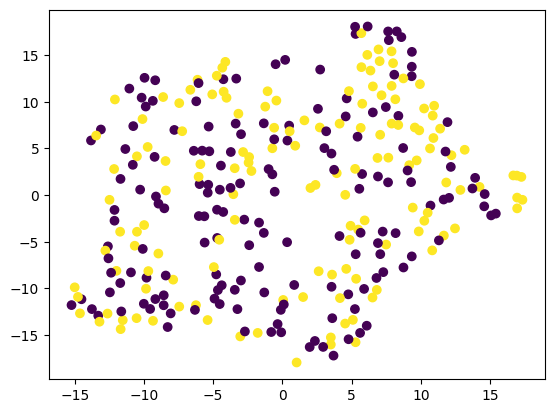

In [108]:
import plotly.express as px

plt.scatter(x=z[:,0], y=z[:,1], c=y_true)
plt.show()